In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

import matplotlib.pyplot as plt

## imports

In [110]:
import cv2
import os
import numpy as np
from PIL import Image

## blanks

In [51]:
def analyze_image(image_path):
    image = cv2.imread(image_path)
    # image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)[1]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # _, gray = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
    # print(gray.shape)
    # plt.imshow(gray)
    std_dev = np.std(gray)
    # laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    # entropy = shannon_entropy(gray)
    # edges = cv2.Canny(gray, 100, 200)
    # edge_density = np.mean(edges)
    
    return std_dev


In [52]:
def plot_metric_distribution(metric_values, metric_name):
    plt.figure(figsize=(10, 6))
    plt.hist(metric_values, bins=30)
    plt.title(f'Distribution of {metric_name}')
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.show()

In [61]:
def main():
    dataset_path = '../data/FUNSD/training_data/classes/'
    categories = ['clean', 'blanks']
    
    all_std_devs = []
    
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for image_file in os.listdir(category_path):
            if image_file.startswith("."): continue
            image_path = os.path.join(category_path, image_file)
            std_dev = analyze_image(image_path)
            
            all_std_devs.append((category, std_dev))
    
    # Plot distributions
    plot_metric_distribution([std for _, std in all_std_devs], 'Standard Deviation')
    
    
    # Print summary statistics
    for metric_name, metric_values in [('Standard Deviation', all_std_devs)]:
        print(f"\n{metric_name} summary:")
        for category in categories:
            category_values = [value for cat, value in metric_values if cat == category]
            print(f"  {category.capitalize()}:")
            print(f"    Min: {min(category_values):.2f}")
            print(f"    Max: {max(category_values):.2f}")
            print(f"    Mean: {np.mean(category_values):.2f}")
            print(f"    Median: {np.median(category_values):.2f}")

In [63]:
import cv2
import numpy as np
from skimage import measure
from collections import defaultdict

def analyze_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image is already binarized
    unique_values = np.unique(image)
    is_binarized = len(unique_values) == 2 and 0 in unique_values and 255 in unique_values
    
    if not is_binarized:
        # If not binarized, calculate standard deviation
        std_dev = np.std(image)
        # Binarize the image for further analysis
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        std_dev = None
        binary = image
    
    # Calculate pixel density (ratio of black pixels)
    pixel_density = 1 - (np.sum(binary == 255) / binary.size)
    
    # Connected component analysis
    labels = measure.label(binary == 0)
    component_sizes = [np.sum(labels == label) for label in range(1, np.max(labels) + 1)]
    num_components = len(component_sizes)
    avg_component_size = np.mean(component_sizes) if component_sizes else 0
    
    # Run length encoding analysis
    def rle_analysis(arr):
        runs = defaultdict(int)
        for row in arr:
            run_lengths = measure.label(row)
            unique, counts = np.unique(run_lengths, return_counts=True)
            for length in counts[1:]:  # Skip background
                runs[length] += 1
        return runs
    
    white_runs = rle_analysis(binary == 255)
    black_runs = rle_analysis(binary == 0)
    
    avg_white_run = np.mean(list(white_runs.keys())) if white_runs else 0
    avg_black_run = np.mean(list(black_runs.keys())) if black_runs else 0
    
    return {
        "is_binarized": is_binarized,
        "std_dev": std_dev,
        "pixel_density": pixel_density,
        "num_components": num_components,
        "avg_component_size": avg_component_size,
        "avg_white_run": avg_white_run,
        "avg_black_run": avg_black_run
    }

def process_dataset(input_folder):
    import os
    results = defaultdict(list)
    
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            image_path = os.path.join(input_folder, filename)
            analysis = analyze_image(image_path)
            
            for key, value in analysis.items():
                results[key].append(value)
    
    return results

def print_summary(results):
    for key, values in results.items():
        if key == "is_binarized":
            print(f"{key}:")
            print(f"  True: {values.count(True)}")
            print(f"  False: {values.count(False)}")
        else:
            print(f"{key}:")
            print(f"  Min: {min(values):.2f}")
            print(f"  Max: {max(values):.2f}")
            print(f"  Mean: {np.mean(values):.2f}")
            print(f"  Median: {np.median(values):.2f}")
        print()

In [67]:
input_folder = "../data/FUNSD/training_data/classes/blanks/"
results = process_dataset(input_folder)
print_summary(results)

is_binarized:
  True: 0
  False: 149

std_dev:
  Min: 0.00
  Max: 106.24
  Mean: 13.26
  Median: 8.70

pixel_density:
  Min: 0.00
  Max: 0.23
  Mean: 0.01
  Median: 0.00

num_components:
  Min: 0.00
  Max: 1037.00
  Mean: 165.52
  Median: 111.00

avg_component_size:
  Min: 0.00
  Max: 563.65
  Mean: 14.42
  Median: 2.71

avg_white_run:
  Min: 0.00
  Max: 145.00
  Mean: 90.00
  Median: 90.11

avg_black_run:
  Min: 0.00
  Max: 120.20
  Mean: 17.16
  Median: 4.71



In [68]:
input_folder = "../data/FUNSD/training_data/classes/blurs/"
results = process_dataset(input_folder)
print_summary(results)

is_binarized:
  True: 0
  False: 298

std_dev:
  Min: 10.48
  Max: 103.19
  Mean: 27.00
  Median: 24.66

pixel_density:
  Min: 0.03
  Max: 0.32
  Mean: 0.14
  Median: 0.12

num_components:
  Min: 5.00
  Max: 870.00
  Mean: 131.82
  Median: 96.00

avg_component_size:
  Min: 6.16
  Max: 4735.80
  Mean: 160.20
  Median: 91.62

avg_white_run:
  Min: 48.58
  Max: 105.98
  Mean: 84.37
  Median: 84.66

avg_black_run:
  Min: 11.37
  Max: 100.86
  Mean: 43.53
  Median: 40.88



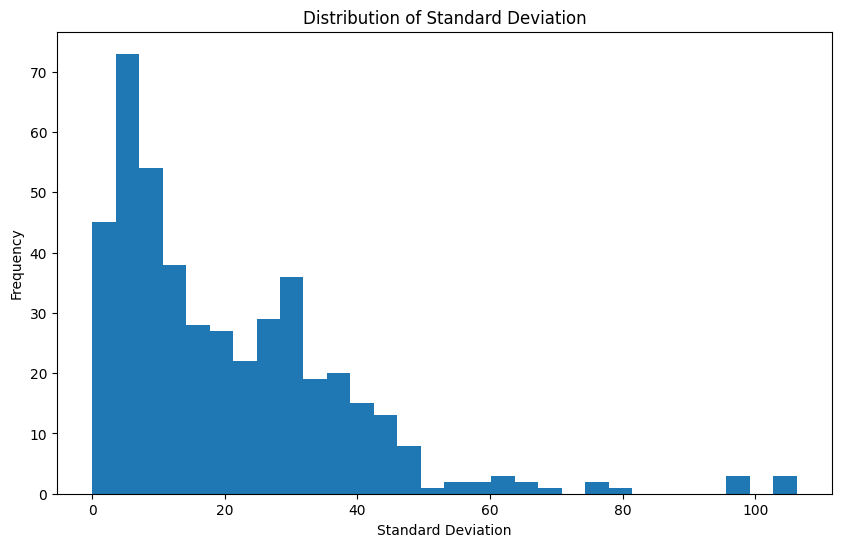


Standard Deviation summary:
  Clean:
    Min: 15.39
    Max: 105.88
    Mean: 35.19
    Median: 32.38
  Blanks:
    Min: 0.00
    Max: 106.24
    Mean: 13.32
    Median: 8.78


In [62]:
main()

### test on sample images

In [94]:
sample1 = "../data/FUNSD/training_data/classes/blanks/blank_0000999294.png"

In [95]:
analyze_image(sample1)

{'is_binarized': False,
 'std_dev': 10.75859697952895,
 'pixel_density': 0.015898437499999973,
 'num_components': 723,
 'avg_component_size': 1.6887966804979253,
 'avg_white_run': 91.9271523178808,
 'avg_black_run': 5.25}

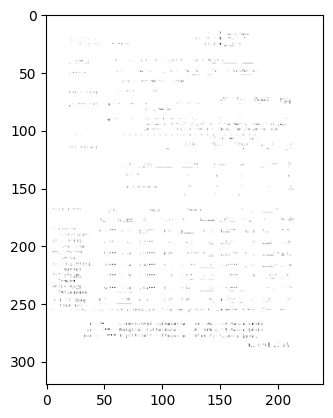

In [96]:
plt.imshow(cv2.imread(sample1))

In [149]:
from skimage.util import crop

In [163]:
def is_blank_document(image_path, 
                      std_dev_threshold=17,
                      pixel_density_threshold=0.02,
                      avg_black_run_threshold=20,
                     crop_percentage=0.8):
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if crop_percentage < 1.0:
        crop_size = int((1 - crop_percentage) * min(image.shape) / 2)
        image = crop(image, ((crop_size, crop_size), (crop_size, crop_size)))
    # Quick check: if standard deviation is above threshold, it's not blank
    if np.std(image) > std_dev_threshold:
        return False, image
    
    # Binarize the image
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Check pixel density
    pixel_density = 1 - (np.sum(binary == 255) / binary.size)
    if pixel_density > pixel_density_threshold:
        return False, image
    
    # Run length encoding analysis for black runs
    def avg_black_run(arr):
        runs = np.diff(np.where(np.concatenate(([arr[0]], arr[:-1] != arr[1:], [True])))[0])[::2]
        return np.mean(runs) if runs.size > 0 else 0
    
    avg_black_run_length = np.mean([avg_black_run(row) for row in (binary == 0)])
    if avg_black_run_length > avg_black_run_threshold:
        return False, image
    
    # If all checks pass, consider it blank
    return True, image

In [3]:
from skimage import filters

def is_blank_document_robust(image_path, 
                             content_threshold=0.01,
                             quadrant_threshold=0.75, crop_percentage=0.7):
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if crop_percentage < 1.0:
        crop_size = int((1 - crop_percentage) * min(image.shape) / 2)
        image = crop(image, ((crop_size, crop_size), (crop_size, crop_size)))
    # Robust binarization using Otsu's method
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    def analyze_region(region):
        pixel_density = 1 - (np.sum(region == 255) / region.size)
        print(pixel_density)
        return pixel_density > content_threshold

    # Analyze whole image
    if analyze_region(binary):
        return False, binary # Not blank if whole image has significant content

    # Divide image into quadrants and analyze each
    h, w = binary.shape
    quadrants = [
        binary[:h//2, :w//2], binary[:h//2, w//2:],
        binary[h//2:, :w//2], binary[h//2:, w//2:]
    ]
    
    blank_quadrants = sum(not analyze_region(q) for q in quadrants)
    
    # If most quadrants are blank, consider the document blank
    return (blank_quadrants / len(quadrants) >= quadrant_threshold) , binary

In [4]:
is_blank_document_robust('../data/FUNSD/training_data/classes/blanks/blank_88547278_88547279.png')

NameError: name 'cv2' is not defined

In [241]:
incorrect = []
for image in Path("../data/FUNSD/training_data/classes/blanks/").iterdir():
    if image.name.startswith("."): continue
    image = str(image)
    verdict, img = is_blank_document_robust(image)
    if not verdict: incorrect.append((Image.fromarray(img), image, analyze_image(image)))

In [242]:
len(incorrect)

52

('../data/FUNSD/training_data/classes/blanks/blank_81749056_9057.png', {'is_binarized': False, 'std_dev': 15.537398544142597, 'pixel_density': 0.027486979166666647, 'num_components': 634, 'avg_component_size': 3.329652996845426, 'avg_white_run': 101.15428571428572, 'avg_black_run': 15.222222222222221})


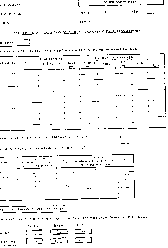

In [292]:
idx = 47
print(incorrect[idx][1:])
incorrect[idx][0]

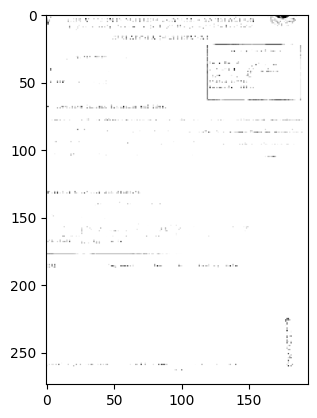

In [228]:
plt.imshow(is_blank_document("../data/FUNSD/training_data/classes/blanks/blank_0001123541.png")[1], cmap='gray')